## 12.4 用变分自编码器生成图像

### 12.4.1 从图像潜在空间中采样

### 12.4.2 图像编辑的概念向量

### 12.4.3 变分自编码器 `Variational autoencoders`
---
`VAE` 的工作原理：
* 编码器模块将输入样本`input_img`转换为图像表示潜在空间的中两个参数`z_mean`和`z_log_var`。
* 我们假定潜在正态分布能够生成输入图像，并从这个分布中随机采样一个点`z, z = z_mean + exp(0.5 * z_log_var) * epsilon`，其中`epsilon(ε)`是一个取值很小的随机张量。
* 解码器模块将潜在空间中的这个点映射回原始输入图像。
---
`VAE`的参数可以通过两个损失函数来训练：
- **重构损失**`reconstruction loss`
- **正则化损失**`regularization loss`

In [ ]:
# exp.
z_mean, z_log_var = encoder(input_img)
z                 = z_mean + exp(0.5 * z_log_var) * epsilon
reconstructed_img = decoder(z)
model             = Model(input_img, reconstructed_img)

### 12.4.4 用`keras`实现变分自编码器

In [15]:
from tensorflow import keras
from tensorflow.keras import layers

import tensorflow as tf
import numpy as np

#### [C] 12.24 `VAE`编码器网络

In [4]:
latent_dim = 2 # 潜在空间的维度：二维平面

encoder_inputs = keras.Input(shape=(28, 28, 1))
x              = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
x              = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
x              = layers.Flatten()(x)
x              = layers.Dense(16, activation="relu")(x)
z_mean         = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var      = layers.Dense(latent_dim, name="z_log_var")(x)
encoder        = keras.Model(encoder_inputs, [z_mean, z_log_var], name="encoder")

In [5]:
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 conv2d_4 (Conv2D)              (None, 14, 14, 32)   320         ['input_3[0][0]']                
                                                                                                  
 conv2d_5 (Conv2D)              (None, 7, 7, 64)     18496       ['conv2d_4[0][0]']               
                                                                                                  
 flatten_2 (Flatten)            (None, 3136)         0           ['conv2d_5[0][0]']               
                                                                                            

#### [C] 12.25 潜在空间采样层

In [7]:
class Sampler(layers.Layer):

    def call(self, z_mean, z_log_var):

        batch_size = tf.shape(z_mean)[0]
        z_size     = tf.shape(z_mean)[1]
        epsilon    = tf.random.normal(shape=(batch_size, z_size))  # 从正态分布中随机抽取一个向量批量

        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

#### [C] 12.26 `VAE`解码网络，将潜在空间点映射为图像

In [8]:
latent_inputs   = keras.Input(shape=(latent_dim, ))
x               = layers.Dense(7 * 7 * 64, activation="relu")(latent_inputs)
x               = layers.Reshape((7, 7, 64))(x)
x               = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
x               = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
decoder_outputs = layers.Conv2D(1, 3, activation="sigmoid", padding="same")(x)
decoder         = keras.Model(latent_inputs, decoder_outputs, name="decoder")

In [9]:
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 2)]               0         
                                                                 
 dense_3 (Dense)             (None, 3136)              9408      
                                                                 
 reshape (Reshape)           (None, 7, 7, 64)          0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 14, 14, 64)       36928     
 nspose)                                                         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 28, 28, 32)       18464     
 ranspose)                                                       
                                                                 
 conv2d_6 (Conv2D)           (None, 28, 28, 1)         289 

#### [C] 12.27 使用自定义`train_step()`的`VAE`模型
---
非监督学习模型

In [13]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super().__init__(**kwargs)
        self.encoder                     = encoder
        self.decoder                     = decoder
        self.sampler                     = Sampler()
        self.total_loss_tracker          = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(name="reconstruction_loss")
        self.kl_loss_tracker             = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [self.total_loss_tracker,
                self.reconstruction_loss_tracker,
                self.kl_loss_tracker]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var   = self.encoder(data)
            z                   = self.sampler(z_mean, z_log_var)
            reconstruction      = decoder(z)
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    keras.losses.binary_crossentropy(data, reconstruction),
                    axis=(1, 2)
                )
            )
            kl_loss    = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            total_loss = reconstruction_loss + tf.reduce_mean(kl_loss)
        
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        
        return {
            "total_loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

#### 12.28 [C] 训练`VAE`

In [16]:
(x_train, _), (x_test, _) = keras.datasets.mnist.load_data()

mnist_digits = np.concatenate([x_train, x_test], axis=0)
mnist_digits = np.expand_dims(mnist_digits, -1).astype("float32") / 255

vae = VAE(encoder, decoder)

vae.compile(optimizer=keras.optimizers.Adam(), run_eagerly=True)

vae.fit(mnist_digits, epochs=2, batch_size=128)

Epoch 1/2
547/547 [==============================] - 121s 220ms/step - total_loss: 211.8734 - reconstruction_loss: 209.2529 - kl_loss: 2.6202
Epoch 2/2
547/547 [==============================] - 124s 227ms/step - total_loss: 173.1022 - reconstruction_loss: 169.0800 - kl_loss: 4.0223


#### [C] 12.29 从二维潜在空间中采样图像网格

1/1 [==============================] - 0s 23ms/step


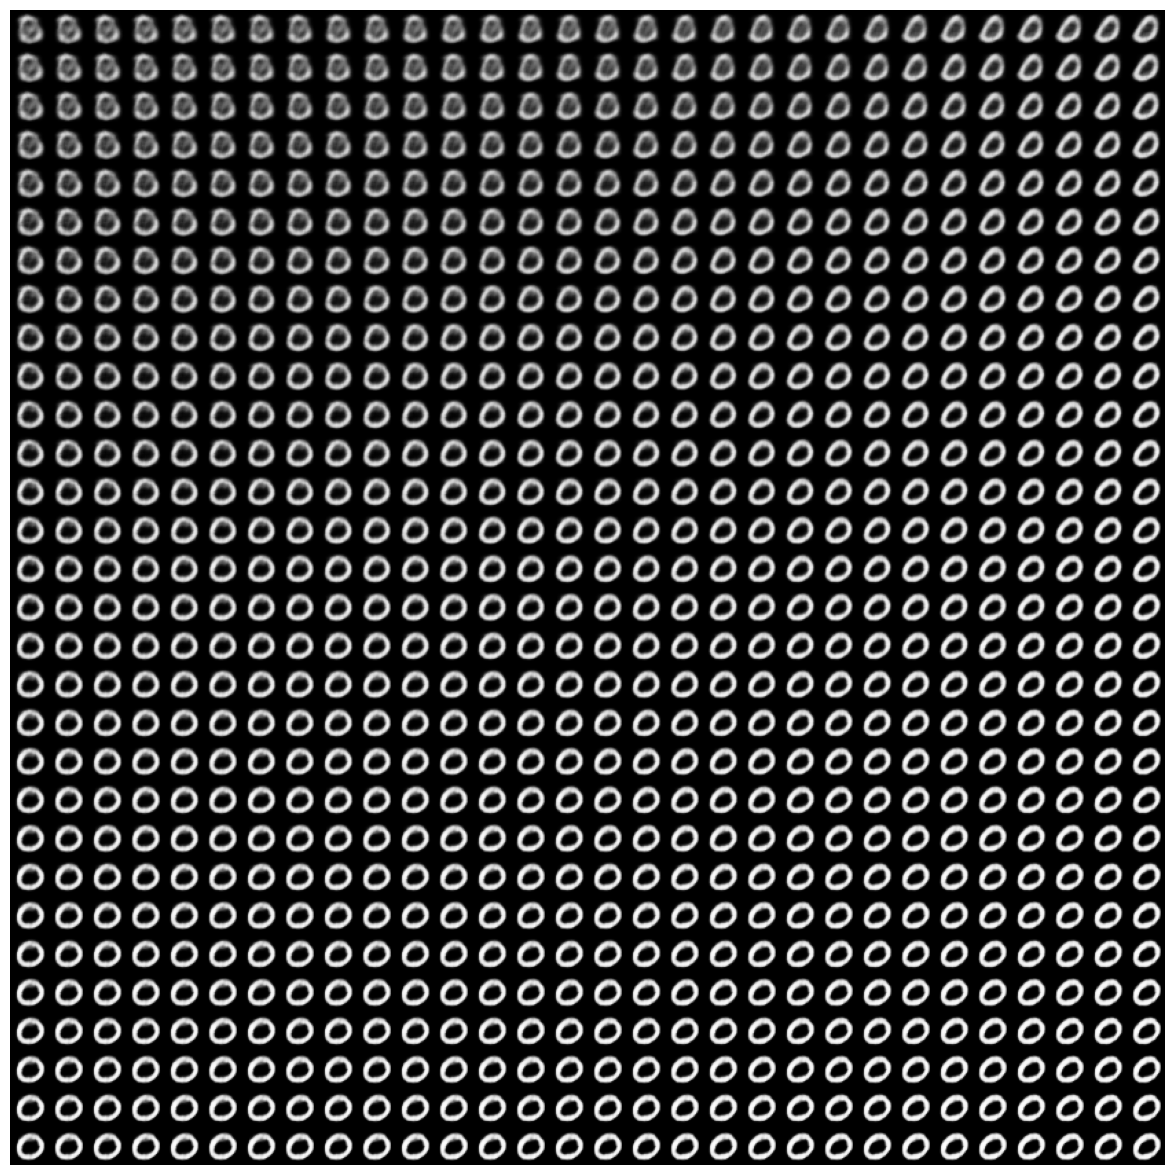

In [17]:
import matplotlib.pyplot as plt

n          = 30
digit_size = 28
figure     = np.zeros((digit_size * n, digit_size * n))

grid_x = np.linspace(-1, 1, n)
grid_y = np.linspace(-1, 1, n)[::-1]

for i, yi in enumerate(grid_y):
    for j, xi in enumerate(grid_x):
        z_sample  = np.array([[xi, yi]])
        x_decoded = vae.decoder.predict(z_sample)
        digit     = x_decoded[0].reshape(digit_size, digit_size)
        figure[
            i * digit_size : (i + 1) * digit_size,
            j * digit_size : (j + 1) * digit_size,
        ] = digit

plt.figure(figsize=(15, 15))
start_range    = digit_size // 2
end_range      = n * digit_size + start_range
pixel_range    = np.arange(start_range, end_range, digit_size)
sample_range_x = np.round(grid_x, 1)
sample_range_y = np.round(grid_y, 1)

plt.xticks(pixel_range, sample_range_x)
plt.yticks(pixel_range, sample_range_y)

plt.xlabel("z[0]")
plt.ylabel("z[1]")

plt.axis("off")

plt.imshow(figure, cmap="Greys_r")